In [1]:
# Class dependencies
from model_sam import OrigamiNetwork
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import pickle


# Other analysis libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from sklearn.datasets import load_digits

Epoch 300/300 - Train Acc: 0.9878 - Val Acc: 0.9549: 100%|██████████| 300/300 [00:24<00:00, 12.43it/s]


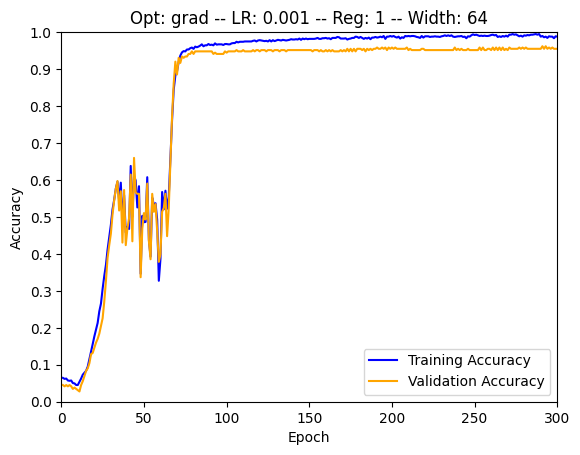

0.9416666666666667


In [2]:
# import small digits dataset

digits = load_digits()
X = digits.data
y = digits.target

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

# set up the model
model = OrigamiNetwork(layers=2, epochs=300, optimizer='grad',learning_rate=0.001)
model.fit(X_train, y_train, X_val, y_val)

# get the predictions
y_hat = model.predict(X_test)
print(accuracy_score(y_test, y_hat))


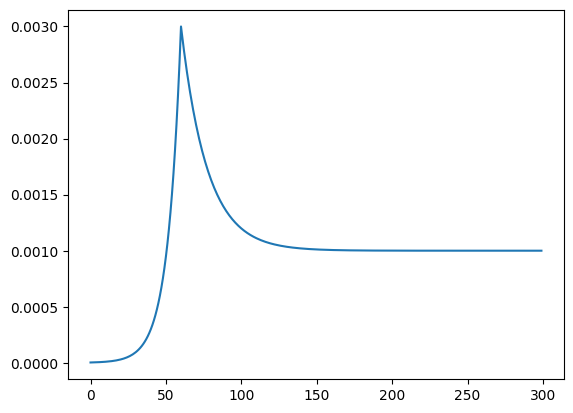

In [3]:
plt.plot(model.learning_rate_history)
plt.show()

In [4]:
n = 100
batch_size = 15

def get_batches(n, batch_size):
    indices = np.arange(n)
    print(np.sum(indices))
    print("begin")
    np.random.shuffle(indices)
    num_batches = n // batch_size

    # Loop through the different batches and get the batches
    batches = [indices[i*batch_size:(i+1)*batch_size].tolist() for i in range(num_batches)]

    # Handle the remaining points
    remaining_points = indices[num_batches*batch_size:]
    counter = len(remaining_points)
    i = 0

    # Fill the remaining points into the batches
    while counter > 0:
        batches[i % len(batches)].append(remaining_points[i])
        i += 1
        counter -= 1

    # Return the batches
    return batches


batches = get_batches(n, batch_size)
total = 0
for batch in batches:
    print(batch)
    print(len(batch))
    print()
    total += np.sum(batch)
    
print(total)


def randomize_batches(self):
    """
    Randomize the batches for stochastic gradient descent
    Parameters:
        None
    Returns:
        batches (list) - A list of batches of indices for training
    """
    # Get randomized indices and calculate the number of batches
    indices = np.arange(self.n)
    np.random.shuffle(indices)
    num_batches = self.n // self.batch_size

    # Loop through the different batches and get the batches
    batches = [indices[i*self.batch_size:(i+1)*self.batch_size].tolist() for i in range(num_batches)]

    # Handle the remaining points
    remaining_points = indices[num_batches*self.batch_size:]
    counter = len(remaining_points)
    i = 0

    # Fill the remaining points into the batches
    while counter > 0:
        batches[i % len(batches)].append(remaining_points[i])
        i += 1
        counter -= 1

    # Return the batches
    return batches

4950
begin
[14, 16, 93, 1, 58, 90, 62, 64, 32, 74, 82, 71, 84, 13, 42, 56, 44]
17

[67, 99, 83, 8, 76, 54, 55, 77, 65, 31, 68, 25, 4, 49, 78, 39, 70]
17

[10, 96, 73, 92, 61, 36, 57, 94, 75, 47, 88, 5, 24, 29, 95, 43, 86]
17

[11, 22, 7, 51, 23, 19, 27, 79, 28, 6, 41, 45, 63, 48, 26, 18, 66]
17

[85, 17, 46, 80, 2, 12, 9, 21, 15, 52, 35, 20, 60, 30, 34, 87]
16

[98, 91, 69, 40, 37, 53, 59, 81, 38, 89, 33, 3, 50, 72, 97, 0]
16

4950
